# Example of conversion to BIDS from MRI
## (EEG approach mentioned for self study)

## Conversion of MRI data with heudiconv

Adapted in part from https://neuroimaging-core-docs.readthedocs.io/en/latest/pages/heudiconv.html

### Getting data

This is a dataset from https://osf.io/5q8fb which we know to be a zip file
```bash
cd
cd fair_data
wget -O heudiconv_data.zip https://osf.io/5q8fb/download
```

Let's unzip it into a new directory `heudiconv_data` 

```bash
unzip heudiconv_data.zip -d heudiconv_data
```

### Running heudiconv

*Heudiconv*, is a tool following a trial-and-error approach (i.e. a *heuristic*) to convert MRI data from Dicom format to Nifti format while organizing all files along the BIDS specifications.

*Note*: HeuDiConv stands for Heuristic Dicom Conversion

The trial and error approach consists in trying to match (i.e. translate) the file names generated by the scanner to the corresponding modality names. In our case, the aim is to:
- identify T1 weighted data (type `anat`, modality `T1w`)
- identify resting state data (without motion correction) before TMS (type `func`, modality `task-rest`, `run-01`)
- identify resting state data (without motion correction) after TMS (type `func`, modality `task-rest`, `run-02`)
- convert all mentioned data to BIDS format

The procedure is done in two steps:
1. Run heudiconv without conversion (`-c none`) from Dicom to Nifti, to assess how to match file names with their corresponding modalities
2. Run heudiconv with conversion (`-c dcm2niix`) to implement the matching found in step 1

#### Step without conversion

Go in the right directory, and activate our conda neuroimaging environment

```bash
cd
cd heudiconv_data
conda activate ni38
```

Run heudiconv without conversion

```bash
heudiconv -d Dicom/{subject}/*/*.dcm -o bids/ -f convertall -s 219 -c none
```
With:
* `-d <glob expression>`: the path to the data, with `{subject}` replaced by the argument of the `-s` option
* `-o <output_dir>`: the path to the output directory
* `-f <heuristic_type>`: the type of heuristic to use (which will create the associated template script)
* `-s <subject_id>:` the subject id(s) (typically only one subject is indicated for the first step without conversion)
* `-c <convertor>`: the name of the convertor to use (typically `dcm2niix` but in this case we do not want any conversion)

This creates a hidden directory (starting with .) `.heudiconv` in the output directory `bids` (use `ls -a` or `tree -a` to also display hidden files and directories):

```bash
$ cd bids
$ tree -a
.
└── .heudiconv
    └── 219
        └── info
            ├── 219.auto.txt
            ├── 219.edit.txt
            ├── dicominfo.tsv
            ├── filegroup.json
            └── heuristic.py
```

We are specifically interested in the two files:
* `dicominfo.tsv` containing all the information `heudiconv` found about our files
* `heuristic.py` which contains a skeleton of the code which will help converting our files with their associated modalities.

First let's copy the `heuristic.py` template in a safe location, not at risk of being overwritten by `heudiconv` (the files in `.heudiconv` can be overwritten every time we run `heudiconv`).

```bash
mkdir code
cp .heudiconv/219/info/heuristic.py code
```
*Note*: the directory `code` is ignore by BIDS validation tools

Now, let's have a look at the dicom information in `dicominfo.tsv` and in the template `heuristic.py` that we will edit. 

In [1]:
import pandas as pd
ds = pd.read_csv('heudiconv_data/bids/.heudiconv/219/info/dicominfo.tsv', sep='\t', header=0)
ds

The main aim is to create in the `heuristic.py`'s `infotodict` function a dictionary `info` to associate to each modality the corresponding series id (i.e. the proper dicom directory)

```python
info[my_modality_key] = ["series_id_X", "series_id_Y", ...]
```

The modality key has to indicate what should be the proper bids path for that modality, and is created with the helper function `create_key`:
```python
anat_t1w = create_key('sub-{subject}/anat/sub-{subject}_T1w')
```

*Note*: if your data have sessions, use instead
```python
anat_t1w = create_key('sub-{subject}/{session}/anat/sub-{subject}_{session}_T1w')
```

So to add the T1 mprage sequence to our BIDS structure, that we identifed as having the series id `13-T1_mprage_1mm`, we would simply need to define `info` as:
```python
info[anat_t1w] = ['13-T1_mprage_1mm']
```
*Note*: the list has only one element because we run only one T1 sequence

In practice the series id can change from subject to subject, (e.g. sequence interrupted an re-run which will generate a different sequence integer), so instead of indicating ourselves the `series_id` in this list, we let the function `infotodict` iterate over all the series `s` (i.e. over the rows of `dicominfo.tsv`) and we use robust criteria to pick the series we would like to keep for bids conversion, for example:
```python
    if ('mprage' in s.protocol_name) and (s.dim3 == 176):
        info[anat_t1w].append(s.series_id)
```

#### Step with conversion

Let's see now an example of converting the files matching the `T1w` modality, and the files matching the resting state fMRI pre-TMS. After that, as an exercise, you will add to the `heuristic.py` file the code to also convert the resting state fMRI post-TMS. 

The steps are to:
* create all your custom keys with `create_key`
* add these newly key objects to initialize the `info` dictionary
* edit the loop on all series so that for a given modality with `mod_key`, the series of interest are appended to the list `info[mod_key]`

Before practicing yourself, let's check the current script converting T1 and resting state fMRI pre-TMS works:
* this time we use the `dcm2niix` converter with `-c dcm2niix`
* we want the output formatted with the bids structure, so with use the `-b` flag
* we do not want to be overwhelmed with all the DICOM metadata so we output the minimum amount with `--minmeta`
* in case we do subsequent trials, to avoid writing errors we forced overwriting existing files with `--overwrite`
```bash
heudiconv -d Dicom/{subject}/*/*.dcm -o bids/ -f bids/code/heuristic_v1.py \
            -s 219 -c dcm2niix -b --minmeta --overwrite
```

**Exercise**: modify the script to also convert resting state fmri post TMS as `run-02` of the rest task. 

### Repeat for each session, or write a for loop if all sessions have same DICOM structure

In this example no need for anything else as it was a toy dataset with a single session

# (Optional) Conversion of EEG data with data2bids

Documentation: http://www.fieldtriptoolbox.org/reference/data2bids/

Use cases of data2bids: http://www.fieldtriptoolbox.org/example/bids/

The `data2bids` function is a Matlab function available from github [here](https://github.com/fieldtrip/fieldtrip/blob/master/data2bids.m)

Let's look at the example `http://www.fieldtriptoolbox.org/workshop/madrid2019/bids_sedation/`

## Getting data

```bash
wget https://www.repository.cam.ac.uk/handle/1810/252736
```

```bash
unzip heudiconv_data.zip -d heudiconv_data
```

## Applying bids2data function

The equivalent of the `heudiconv` mapping function is a config structure in matlab, `cfg ` in the example. Make sure to look in details how it is defined, then run the example.

# Validation and exploration of BIDS dataset

Now time to validate the BIDS structure. This is important to make sure everything it where it should be. You could go to the online BIDS validator [here](https://bids-standard.github.io/bids-validator/) (the validation happens client-side so no data is transmitted to the website) or use a locally installed JavaScript version of it, with:
```bash 
bids-validator <path to bids directory>
```

**Exercise**: validate the bids data you obtained after finishing the last exercise

## Exploring a BIDS dataset

The python package `pybids` offers convenient functions to parse a BIDS dataset. At the heart of this package is a `BIDSLayout` object which offers a representation of the the whole dataset, and can be queried in many different ways. 

In [1]:
from bids import BIDSLayout
import os

data_dir = os.path.join('heudiconv_data', 'bids')
bids_layout = BIDSLayout(data_dir)
bids_layout

/opt/conda/shared/envs/ni38/lib/python3.8/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


BIDS Layout: .../fair_data/heudiconv_data/bids | Subjects: 1 | Sessions: 0 | Runs: 1

The simplest (and least specific output) is to get everything with the `.get()` method without arguments.

In [2]:
bids_layout.get()

[<BIDSFile filename='/home/brainhacker/fair_data/heudiconv_data/bids/CHANGES'>,
 <BIDSJSONFile filename='/home/brainhacker/fair_data/heudiconv_data/bids/dataset_description.json'>,
 <BIDSJSONFile filename='/home/brainhacker/fair_data/heudiconv_data/bids/participants.json'>,
 <BIDSDataFile filename='/home/brainhacker/fair_data/heudiconv_data/bids/participants.tsv'>,
 <BIDSFile filename='/home/brainhacker/fair_data/heudiconv_data/bids/README'>,
 <BIDSJSONFile filename='/home/brainhacker/fair_data/heudiconv_data/bids/sub-219/anat/sub-219_T1w.json'>,
 <BIDSImageFile filename='/home/brainhacker/fair_data/heudiconv_data/bids/sub-219/anat/sub-219_T1w.nii.gz'>,
 <BIDSJSONFile filename='/home/brainhacker/fair_data/heudiconv_data/bids/sub-219/func/sub-219_task-rest_run-01_bold.json'>,
 <BIDSImageFile filename='/home/brainhacker/fair_data/heudiconv_data/bids/sub-219/func/sub-219_task-rest_run-01_bold.nii.gz'>,
 <BIDSDataFile filename='/home/brainhacker/fair_data/heudiconv_data/bids/sub-219/func/s

We can restrict the output, for example by only looking at the top 5 entries, and only displaying the filenames)

In [3]:
bids_layout.get(return_type='filename')[:3]

['/home/brainhacker/fair_data/heudiconv_data/bids/CHANGES',
 '/home/brainhacker/fair_data/heudiconv_data/bids/dataset_description.json',
 '/home/brainhacker/fair_data/heudiconv_data/bids/participants.json']

Another useful return type is `subject` to get a list of all the subjects in our study (although in our toy dataset it is just one), or the locations of their data.

In [4]:
bids_layout.get(return_type='id', target='subject')

['219']

In [5]:
bids_layout.get(return_type='dir', target='subject')

['/home/brainhacker/fair_data/heudiconv_data/bids/sub-219']

*Note*: in this case we need to indicate what we would like the `id` of. This is done with the parameter `target` which can be `"subject"`, `"run"`, `"session"`, etc.

Typically, you will want to only get files from a specific subject, or/and a specific modality. This is easily accomplished with `pybids` with the following statement: 

In [6]:
bids_layout.get(subject='219', suffix='T1w', return_type='filename', extension='nii.gz')

['/home/brainhacker/fair_data/heudiconv_data/bids/sub-219/anat/sub-219_T1w.nii.gz']

**Exercise** Use `pybids` to get the list of `run` `id`s for the images of type `bold` (i.e. fmri) for subject `219` (it should be `[1,2]` as we converted two runs of fmri data for that subject).

Even more specific queries could be obtained, according to file attributes and metadata

In [9]:
t1_file = bids_layout.get(subject='219', suffix='T1w', extension='nii.gz')[0]

In [12]:
t1_file.get_entities()

{'datatype': 'anat', 'extension': 'nii.gz', 'subject': '219', 'suffix': 'T1w'}

In [13]:
t1_file.get_metadata()

{'AcquisitionMatrixPE': 256,
 'AcquisitionNumber': 1,
 'AcquisitionTime': '11:11:22.442500',
 'BaseResolution': 256,
 'BodyPartExamined': 'BRAIN',
 'ConsistencyInfo': 'N4_VE11A_LATEST_20140830',
 'ConversionSoftware': 'dcm2niix',
 'ConversionSoftwareVersion': 'v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0',
 'DeviceSerialNumber': '45424',
 'DwellTime': 1.03e-05,
 'EchoTime': 0.00233,
 'FlipAngle': 12,
 'ImageOrientationPatientDICOM': [-0.0408288,
  0.999138,
  -0.00749368,
  -0.0543137,
  -0.00970819,
  -0.998477],
 'ImageType': ['ORIGINAL', 'PRIMARY', 'M', 'ND', 'NORM'],
 'ImagingFrequency': 123.239,
 'InPlanePhaseEncodingDirectionDICOM': 'ROW',
 'InstitutionAddress': 'North_Warren_Ave_1609_Tucson_Denver_US_85719',
 'InstitutionName': 'University_of_Arizona',
 'InstitutionalDepartmentName': 'Department',
 'InversionTime': 1.1,
 'MRAcquisitionType': '3D',
 'MagneticFieldStrength': 3,
 'Manufacturer': 'Siemens',
 'ManufacturersModelName': 'Skyra',
 'Modality': 'MR',
 'PartialFourier': 1,
 'Pat

Finding all of your files acquired on a Siemens scanner (actually all our files in this toy dataset) could be obtained with:

In [7]:
bids_layout.get(Manufacturer='Siemens')

[<BIDSImageFile filename='/home/brainhacker/fair_data/heudiconv_data/bids/sub-219/anat/sub-219_T1w.nii.gz'>,
 <BIDSImageFile filename='/home/brainhacker/fair_data/heudiconv_data/bids/sub-219/func/sub-219_task-rest_run-01_bold.nii.gz'>]

## Visualizing a Nifti file

To visualize Nifti files with python, it is convenient to use the `nibabel` package.

A Nifti image object is composed notably of the image data, the image header containing information about the image (voxel size, data type, etc.) and how is this image oriented with respect to a reference space (this orientation is provided by the affine transform, cf next preprocessing lesson).

In [8]:
import nibabel as nib

In [10]:
t1_file

<BIDSImageFile filename='/home/brainhacker/fair_data/heudiconv_data/bids/sub-219/anat/sub-219_T1w.nii.gz'>

In [11]:
t1 = nib.load(t1_file)

In [12]:
t1_data = t1.get_fdata()
t1_header = t1.header # the .get_header() method is deprecated
t1_affine = t1.affine # the .get_affine() method is deprecated

In [13]:
t1_data

array([[[21.,  4., 17., ...,  0.,  0.,  0.],
        [17.,  6., 10., ...,  0.,  0.,  0.],
        [18.,  7.,  9., ...,  1.,  1.,  0.],
        ...,
        [ 2.,  2.,  4., ...,  0.,  0.,  0.],
        [ 7., 12.,  8., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[11., 11., 10., ...,  0.,  1.,  0.],
        [ 5., 11., 12., ...,  1.,  1.,  0.],
        [ 3.,  8.,  9., ...,  1.,  0.,  0.],
        ...,
        [10., 12.,  8., ...,  0.,  0.,  0.],
        [ 2.,  1.,  3., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 8., 12.,  7., ...,  1.,  2.,  0.],
        [10., 10., 15., ...,  0.,  0.,  0.],
        [15.,  7.,  6., ...,  1.,  0.,  0.],
        ...,
        [ 4.,  2.,  7., ...,  0.,  0.,  0.],
        [ 7.,  4.,  2., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[11.,  7.,  8., ...,  0.,  0.,  0.],
        [ 4., 13., 14., ...,  0.,  0.,  0.],
        [ 4., 10.,  5., ...,  0.,  0.,  0.

The image data is a numpy array so you can apply all your knowledge of `numpy` to manipulated images ! So for example you can plot a slice of the 3D T1 image with the same `imshow` method of the `matplotlib.pyplot` module you were using to plot matrices.

In [17]:
import matplotlib.pyplot as plt

In [18]:
%matplotlib inline

In [14]:
t1_data.shape

(176, 256, 256)

In [20]:
t1_xy_slice_z50 = t1_data[:, :, 70]

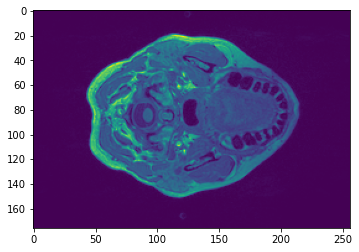

In [21]:
plt.imshow(t1_xy_slice_z50);

In [22]:
t1_xy_slice_z150 = t1_data[:, :, 150]

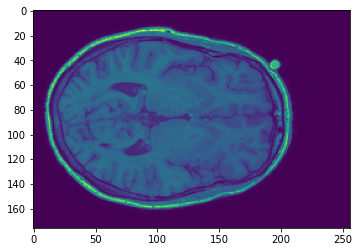

In [23]:
plt.imshow(t1_xy_slice_z150);

**Exercise**
* Get the path to one of the two resting state fMRI (bold) volumes (tip: with BIDS nomenclature, it has a `bold` suffix)
* Keeping in mind that such a volume is 4D (it is a series of 3D volumes through time), plot:
    * The 17th (axial) slice of the 10th volume in time
    * The time variation of one voxel within that slice through all measured time points